In [34]:
from pyspark.sql import SparkSession

In [35]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
import seaborn as sns

In [36]:
spark = SparkSession.builder.appName("features").getOrCreate()

In [61]:
e = spark.read.csv('Data/events.csv',header=True,inferSchema=True,sep=';')

In [49]:
events = spark.read.csv('Data/Datas/events_shot.csv',header=True,inferSchema=True)

In [50]:
df = events.toPandas()

In [73]:
shots = e.filter(e.type == 'Shot')

### Location

In [96]:
shots.select('type','location','shot_statsbomb_xg').show(5,False)

+----+-------------+-----------------+
|type|location     |shot_statsbomb_xg|
+----+-------------+-----------------+
|Shot|[105.6, 44.0]|0.07213958       |
|Shot|[98.6, 25.2] |0.02977089       |
|Shot|[105.5, 47.3]|0.07589752       |
|Shot|[113.4, 38.7]|0.15686217       |
|Shot|[106.2, 36.8]|0.15133068       |
+----+-------------+-----------------+
only showing top 5 rows



### Play pattern

In [98]:
shots.select('type','play_pattern','shot_statsbomb_xg').show(5,False)

+----+-------------+-----------------+
|type|play_pattern |shot_statsbomb_xg|
+----+-------------+-----------------+
|Shot|From Kick Off|0.07213958       |
|Shot|From Keeper  |0.02977089       |
|Shot|From Throw In|0.07589752       |
|Shot|From Corner  |0.15686217       |
|Shot|From Throw In|0.15133068       |
+----+-------------+-----------------+
only showing top 5 rows



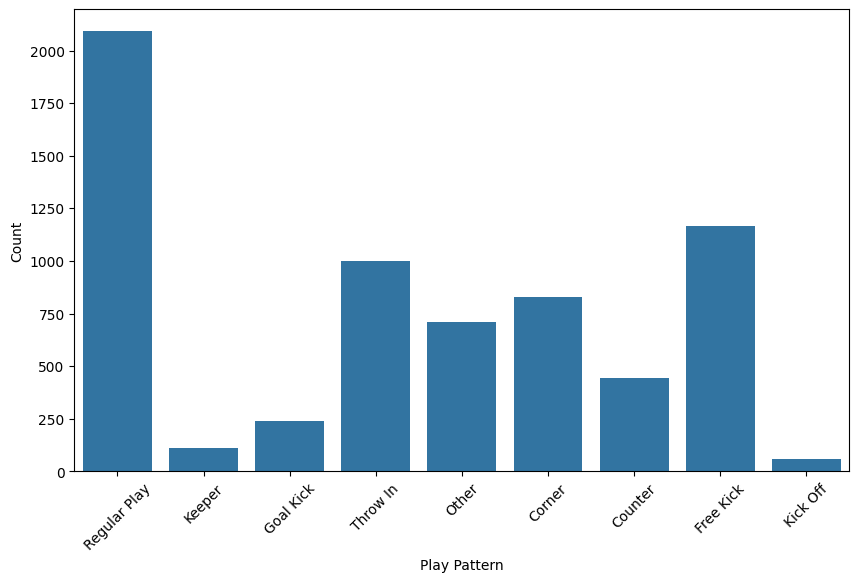

In [90]:
goal_shots = shots.filter(shots['shot_outcome'] == 'Goal')
goal_play_pattern_counts = goal_shots.groupBy("play_pattern").count()
goal_play_pattern_counts_list = goal_play_pattern_counts.collect()
goal_play_patterns = [row['play_pattern'] for row in goal_play_pattern_counts_list]
goal_counts = [row['count'] for row in goal_play_pattern_counts_list]
goal_play_patterns = [pattern.replace("From ", "") if pattern != "Other" else pattern for pattern in goal_play_patterns]
plt.figure(figsize=(10, 6))
sns.barplot(x=goal_play_patterns, y=goal_counts, color='#1F77B4')
plt.xlabel('Play Pattern')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

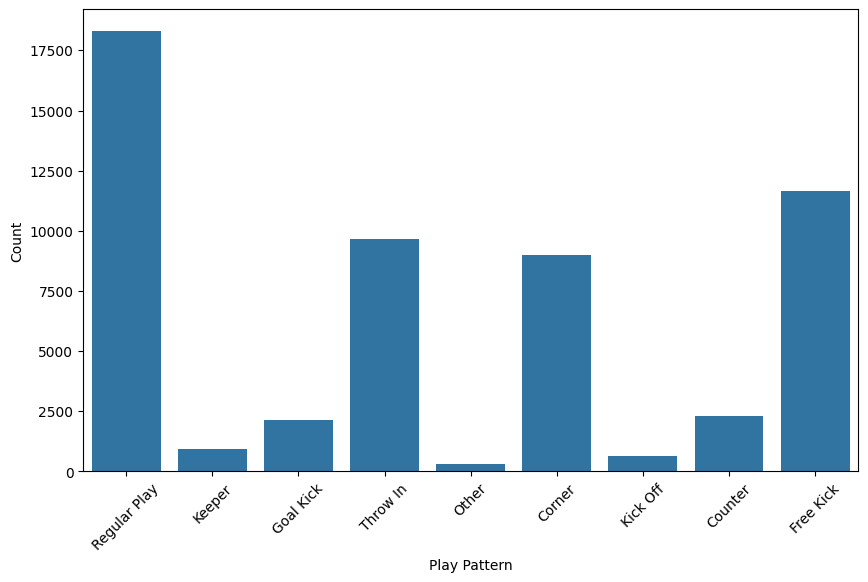

In [ ]:
# Step 1: Filter the DataFrame for Goal shots
goal_shots = shots.filter(shots['shot_outcome'] != 'Goal')
goal_play_pattern_counts = goal_shots.groupBy("play_pattern").count()
goal_play_pattern_counts_list = goal_play_pattern_counts.collect()
goal_play_patterns = [row['play_pattern'] for row in goal_play_pattern_counts_list]
goal_counts = [row['count'] for row in goal_play_pattern_counts_list]
goal_play_patterns = [pattern.replace("From ", "") if pattern != "Other" else pattern for pattern in goal_play_patterns]
plt.figure(figsize=(10, 6))
sns.barplot(x=goal_play_patterns, y=goal_counts, color='#1F77B4')
plt.xlabel('Play Pattern')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Shot Type

In [97]:
shots.select('type','shot_type','shot_statsbomb_xg').show(5,False)

+----+---------+-----------------+
|type|shot_type|shot_statsbomb_xg|
+----+---------+-----------------+
|Shot|Open Play|0.07213958       |
|Shot|Open Play|0.02977089       |
|Shot|Open Play|0.07589752       |
|Shot|Open Play|0.15686217       |
|Shot|Open Play|0.15133068       |
+----+---------+-----------------+
only showing top 5 rows



In [95]:
shots.groupBy("shot_type").count().show()

+---------+-----+
|shot_type|count|
+---------+-----+
|Open Play|57719|
|   Corner|   19|
|Free Kick| 2932|
|  Penalty|  938|
+---------+-----+



### Pitch Visualization

In [56]:
# Set random seed for reproducibility
np.random.seed(42)

# Step 1: K-means clustering
k = 40  # Number of clusters
X = df[['shot_location_x', 'shot_location_y']].values

# Make KMeans reproducible
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

In [57]:

# Step 2: Sample from each cluster
sampled_df = df.groupby('cluster').apply(lambda x: x.sample(min(len(x), 25)))  # Sampling 25 shots per cluster, adjust as needed

# Check if the number of samples is greater than or equal to 3000
if len(sampled_df) > 1000:
    sampled_df = sampled_df.sample(n=1000, random_state=42)  # Get exactly 3000 samples
else:
    print(f"Number of samples is {len(sampled_df)}, which is less than 3000.")

Number of samples is 1000, which is less than 3000.


/tmp/ipykernel_31367/1546939458.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('cluster').apply(lambda x: x.sample(min(len(x), 25)))  # Sampling 25 shots per cluster, adjust as needed


In [58]:
sampled_df_g = sampled_df[sampled_df['goal'] == 1]
sampled_df_ng = sampled_df[sampled_df['goal'] == 0]

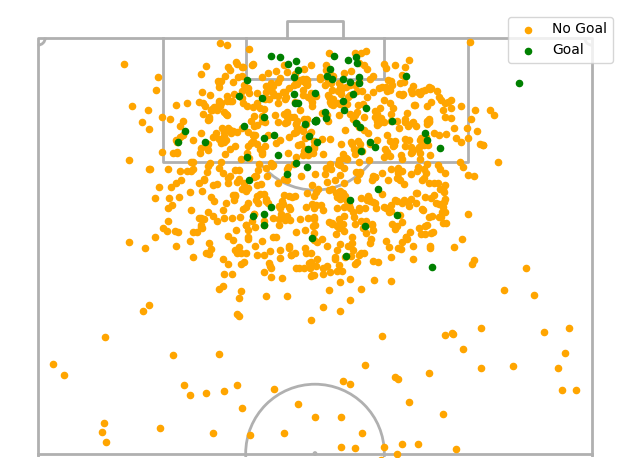

In [59]:
# Step 3: Plotting the representative sample on the pitch
# Fix figure size for consistency
pitch = VerticalPitch(pad_bottom=0.5, pitch_type='statsbomb', half=True, corner_arcs=True, goal_type='box')

# Draw pitch and scatter shots
fig, ax = pitch.draw()

sc1 = pitch.scatter(sampled_df_ng['shot_location_x'], sampled_df_ng['shot_location_y'], color='orange', s=20, label='No Goal', ax=ax)
sc2 = pitch.scatter(sampled_df_g['shot_location_x'], sampled_df_g['shot_location_y'], color='green', s=20, label='Goal', ax=ax)

# Add a legend in a fixed position
ax.legend(loc='upper right')

# Ensure consistent display
plt.tight_layout()
plt.show()